In [1]:
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np

import plotly.express as px

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import glob as glob
import gzip
import shutil
import xarray as xr


In [2]:
path = '/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/raw/liquid/Karlsson2021_basalmelt/basalmelt.nc'

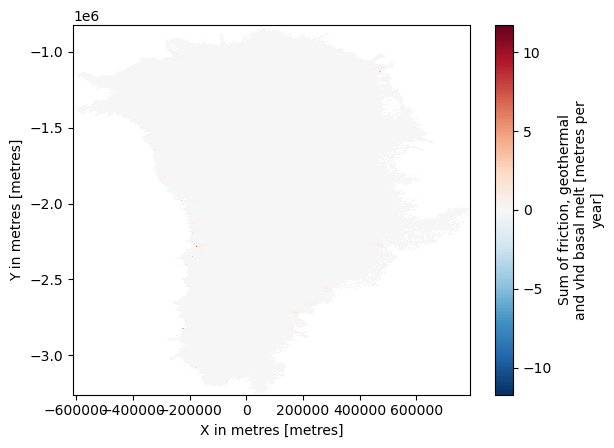

In [4]:
ds = xr.open_dataset(path)
ds['totalmelt'].plot()